In [1]:
from sotip import *
import numpy as np
import scanpy as sc


In [32]:
adata = sc.read_h5ad('p23_spagcn_20211201.h5ad')

In [33]:
adata

AnnData object with n_obs × n_vars = 1241 × 36
    obs: 'row_num', 'point', 'cell_id', 'X1', 'center_rowcoord', 'center_colcoord', 'cell_size', 'category', 'donor', 'Cluster', 'leiden', 'x_pixel', 'y_pixel', 'pred'
    uns: 'Cluster_colors', 'leiden', 'leiden_colors', 'neighbors', 'point_colors', 'pred_colors', 'umap'
    obsm: 'X_umap', 'spatial'
    obsp: 'connectivities', 'distances'

In [34]:
adata.uns['pred_colors'] = ['r','k']

In [35]:
rename_dict = {
    0:'immune',
    1:'tumor'
}
adata.obs['pred'] = adata.obs['pred'].cat.rename_categories(rename_dict)

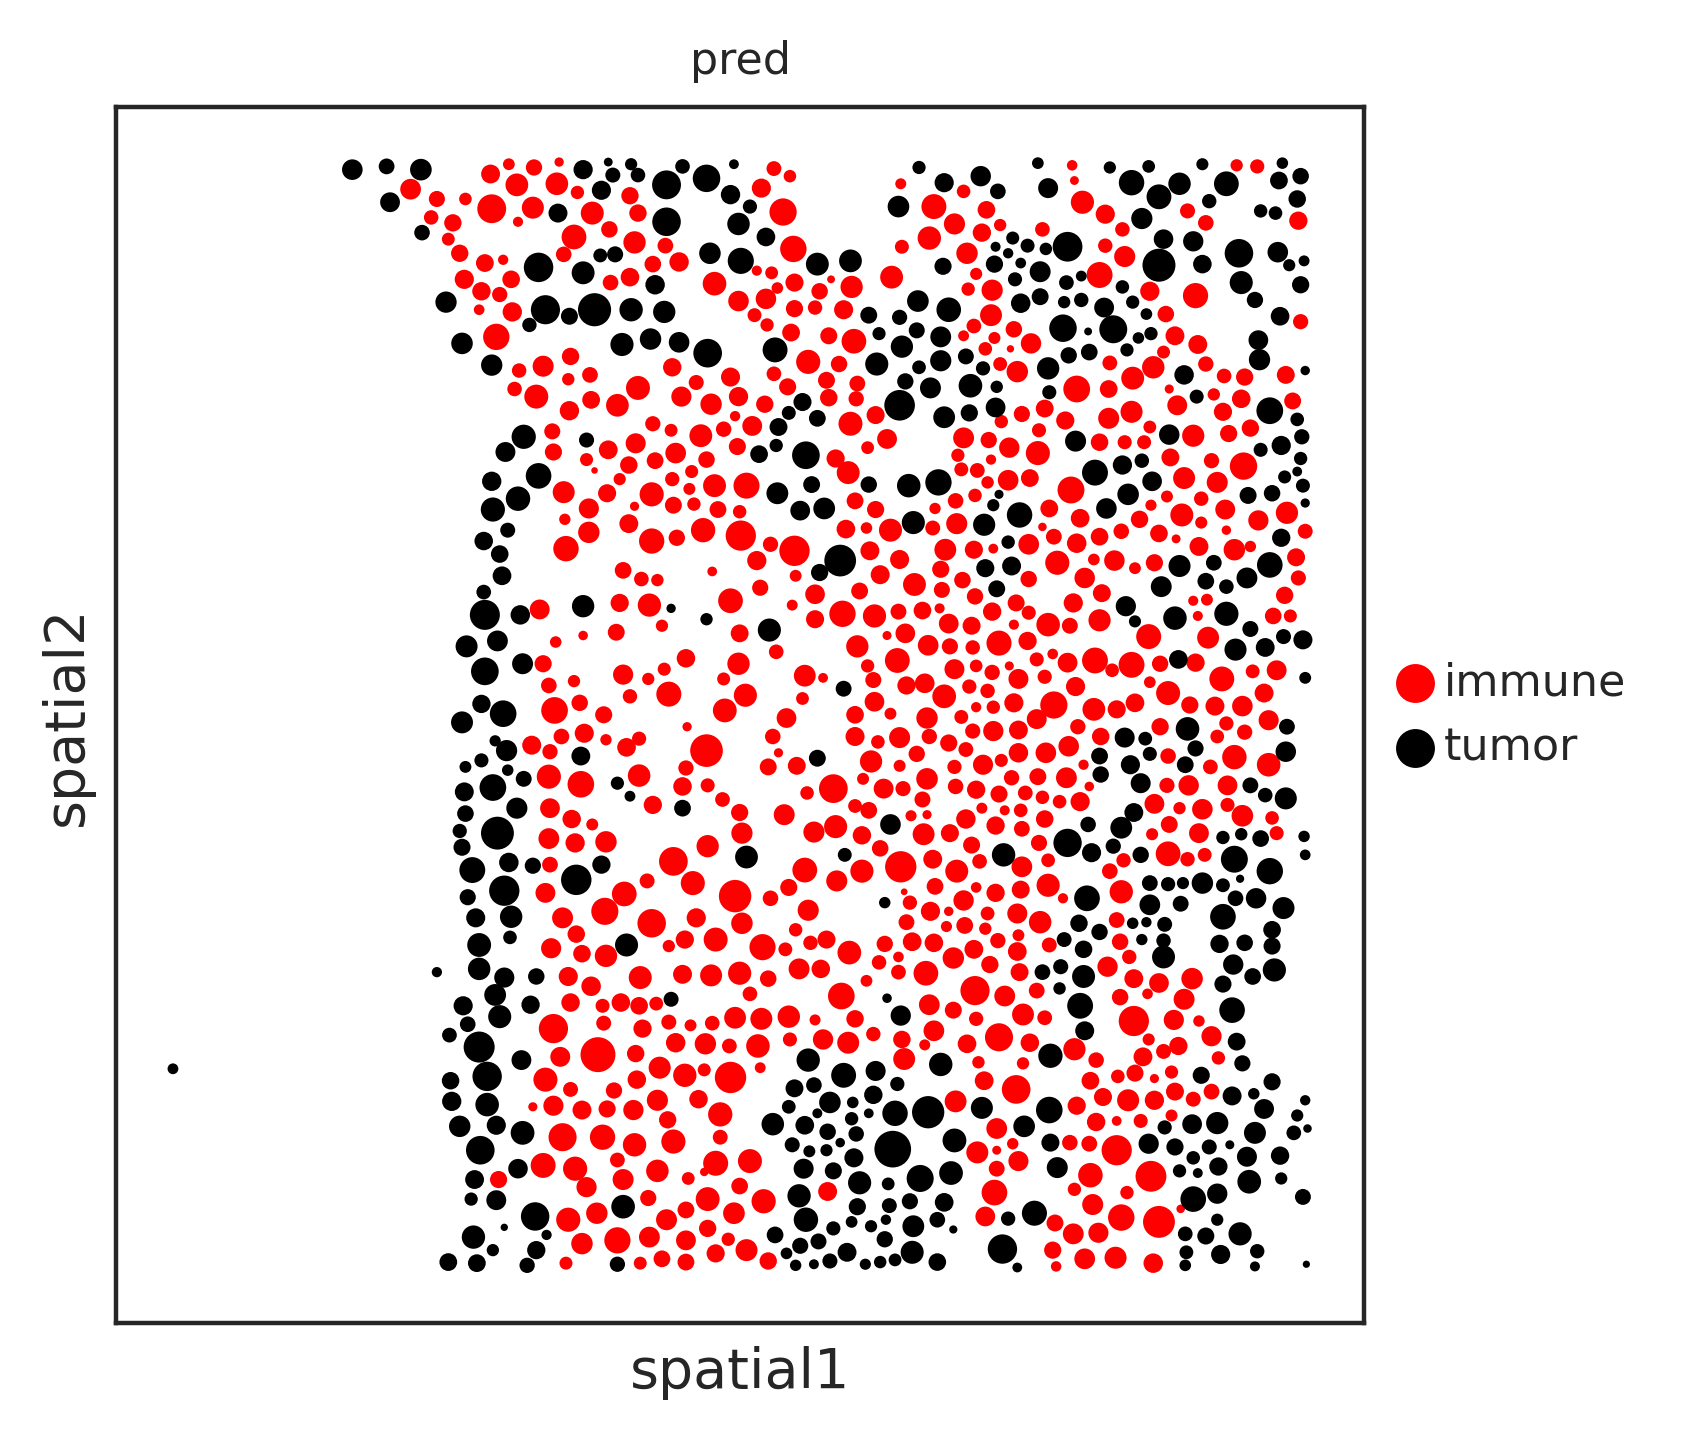

In [36]:
sc.pl.embedding(adata,basis='spatial',color=['pred'],size=adata.obs['cell_size']/10)

In [37]:
# min distance
spatial_mat = adata.obsm['spatial']
dist_mat = squareform(pdist(spatial_mat))

In [38]:
for region in adata.obs['pred'].cat.categories:
    cur_idx = np.where(adata.obs['pred']==region)[0]
    cur_dist_obs = f'min_dist_to_{region}'
    cur_min_dist = np.min(dist_mat[:,cur_idx],axis=1)
    adata.obs[cur_dist_obs] = cur_min_dist

In [39]:
1+1

2

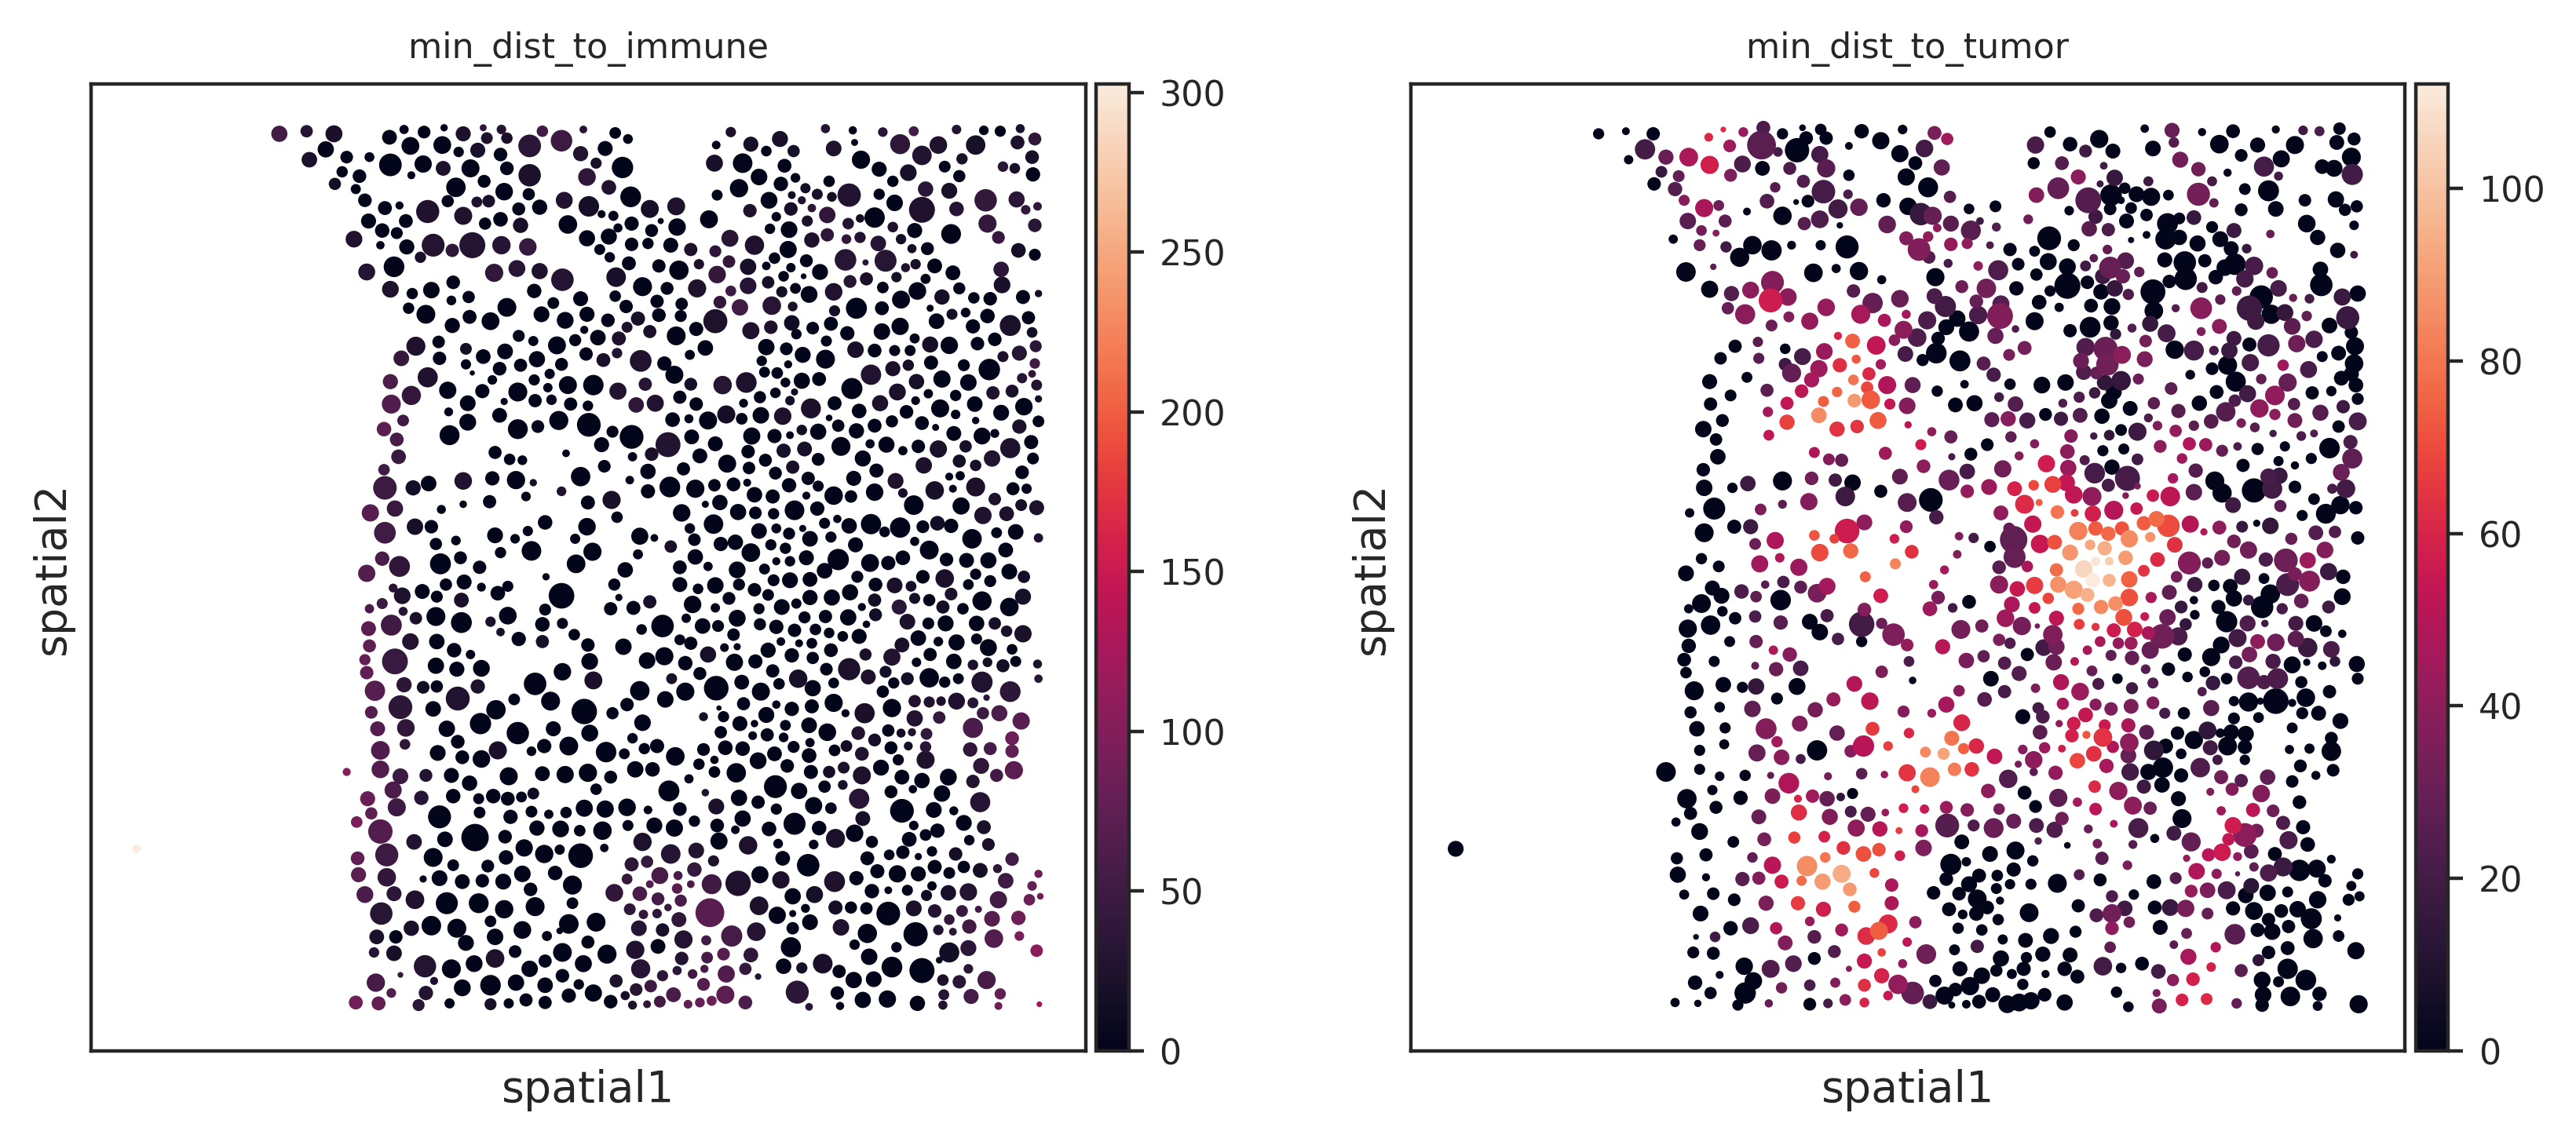

In [40]:
sc.pl.embedding(adata,basis='spatial',color=['min_dist_to_immune','min_dist_to_tumor'],size=adata.obs['cell_size']/10)

# rank sum test polarize

In [41]:
img_sz_um = 400
img_sz_pixel = 1024

boundary_sz_um = 20
boundary_sz_pixel = img_sz_pixel/img_sz_um*boundary_sz_um

In [42]:
boundary_array = np.array(adata.obs['pred'].copy())
min_dist_to_tumor_array = np.array(adata.obs['min_dist_to_tumor'].copy())

In [43]:
boundary_array[(boundary_array=='immune') & (min_dist_to_tumor_array<=boundary_sz_pixel)] = 'boundary'

In [44]:
adata.obs['boundary'] = boundary_array

/root/anaconda3/envs/SOTIP/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'boundary' as categorical


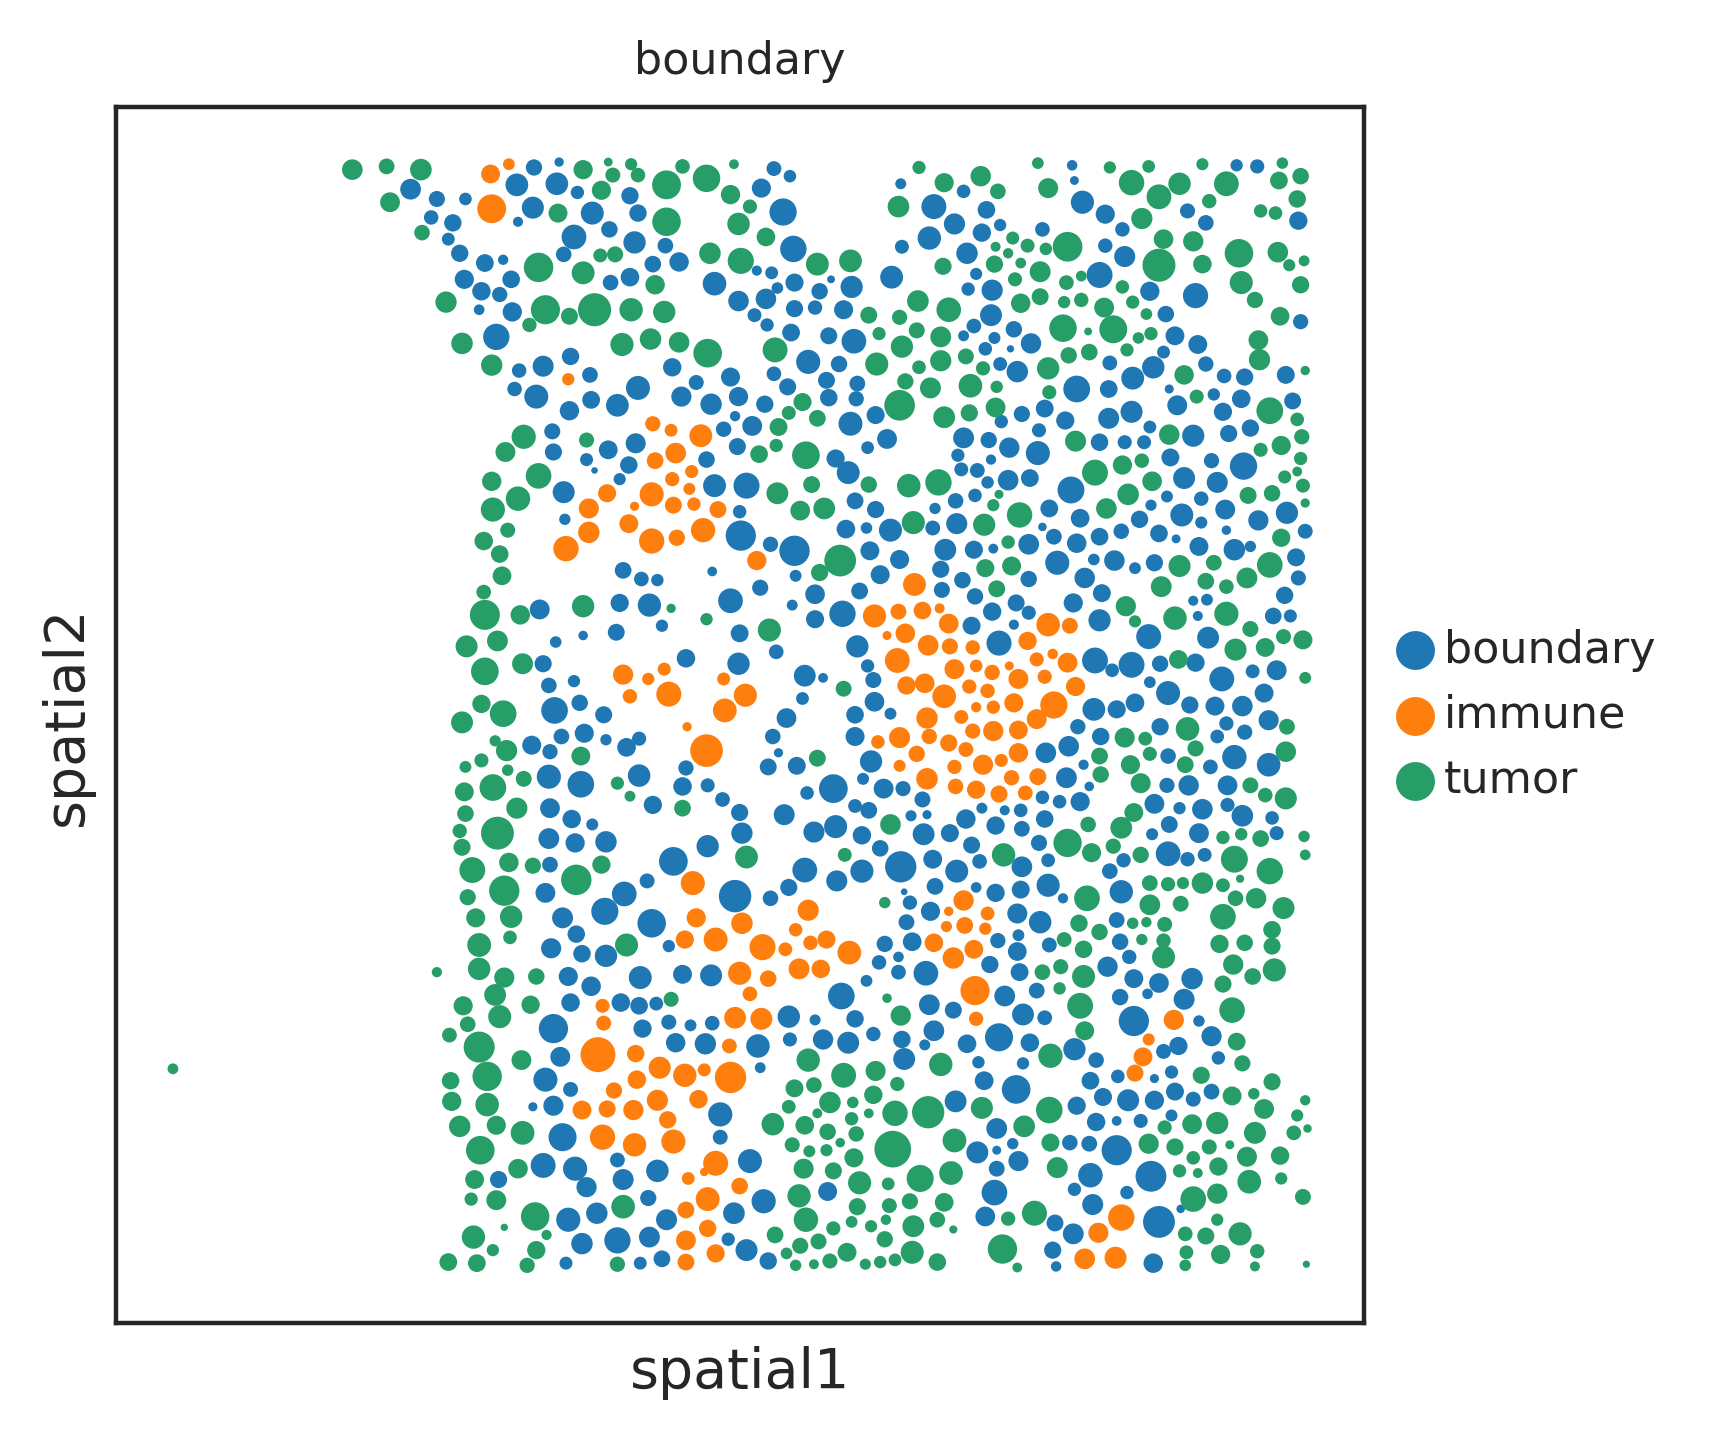

In [45]:
sc.pl.embedding(adata,basis='spatial',color=['boundary'],size=adata.obs['cell_size']/10)

In [46]:

def test_polar(adata,obs,between,protein,var):
    array_0 = np.array(adata[adata.obs[obs]==between[0],protein].X)
    array_1 = np.array(adata[adata.obs[obs]==between[1],protein].X)
    pv = ranksums(array_0,array_1,alternative='greater')[1]
    adata.var[var][np.where(adata.var_names==protein)[0]] = pv
    return pv

In [47]:

var_name = 'spagcn_polar_to_tumor'
adata.var[var_name] = np.zeros(shape=(adata.shape[1]))

# porlar to tumor, ranksum

In [48]:
from pingouin import multicomp
obs = 'boundary'
between = ['boundary','immune']
# var_name = 'spagcn_polar_to_tumor'
for protein in adata.var_names:
    test_polar(adata,obs,between,protein,var_name)
pv_list = np.array(adata.var[var_name])
_,pv_adj = multicomp(pv_list,method='fdr_bh')
adata.var[f'{var_name}_bh'] = pv_adj

In [49]:
gt_polarized = ['CD98','CD36','XBP1','VDAC1','G6PD','PKM2','IDH2','CS','GLUT1','NRF2p','ASCT2','SDHA','ATP5A','CD11c','CD68']

In [50]:
gt_polarized_array = np.zeros(shape=(adata.shape[1],))
adata.var['gt_polarized'] = gt_polarized_array
adata.var['gt_polarized'][adata.var_names.isin(gt_polarized)] = 1

In [51]:
adata.var

,spagcn_polar_to_tumor,spagcn_polar_to_tumor_bh,gt_polarized
H3,0.981237,1.0,0.0
vimentin,0.966517,1.0,0.0
SMA,0.986494,1.0,0.0
CD98,0.995468,1.0,1.0
NRF2p,0.999968,1.0,1.0
CD4,0.999752,1.0,0.0
CD14,0.290531,1.0,0.0
CD45,0.946938,1.0,0.0
PD1,0.999994,1.0,0.0
CD31,0.940667,1.0,0.0


In [52]:
gt_polarized_array = np.zeros(shape=(adata.shape[1],))
adata.var['gt_polarized'] = gt_polarized_array
adata.var['gt_polarized'][adata.var_names.isin(gt_polarized)] = 1

In [53]:
adata.write_h5ad('spagcn_polar_test_p23.h5ad')